### Import all the dependencies

In [1]:
import pandas as pd
import numpy as np
import nltk
from nltk.stem import SnowballStemmer
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import word_tokenize

### Load the dataset

In [2]:
data = pd.read_csv('/Users/himangini/Desktop/CMPE-257/Topic Modeling /liar_dataset/train.tsv', sep='\t')

#### Take a peek at the dataset

In [3]:
data.head()

,file,value,statement,topic,name,occupation,state,party,barely true counts,false counts,half true counts,mostly true counts,pants on fire counts,context,date,edited by,researchedby,source
0,2635.json,FALSE,Says the Annies List political group supports ...,abortion,dwayne-bohac,State representative,Texas,republican,0.0,1.0,0.0,0.0,0.0,a mailer,10/20/10,"Brenda Bell, W. Gardner Selby",Meghan Ashford_Grooms,NaN
1,10540.json,half-true,When did the decline of coal start? It started...,"energy,history,job-accomplishments",scott-surovell,State delegate,Virginia,democrat,0.0,0.0,1.0,1.0,0.0,a floor speech.,NaN,NaN,NaN,NaN
2,324.json,mostly-true,"Hillary Clinton agrees with John McCain ""by vo...",foreign-policy,barack-obama,President,Illinois,democrat,70.0,71.0,160.0,163.0,9.0,Denver,NaN,NaN,NaN,NaN
3,1123.json,FALSE,Health care reform legislation is likely to ma...,health-care,blog-posting,NaN,NaN,none,7.0,19.0,3.0,5.0,44.0,a news release,NaN,NaN,NaN,NaN
4,9028.json,half-true,The economic turnaround started at the end of ...,"economy,jobs",charlie-crist,NaN,Florida,democrat,15.0,9.0,20.0,19.0,2.0,an interview on CNN,NaN,NaN,NaN,NaN


### Data Cleaning and Preprocessing:
1. **Tokenization**: Split the text into sentences and the sentences into words. 
2. **Lowercase** the words and **remove punctuation**.
3. Words that have fewer than 3 characters are removed.
4. All **stopwords** are removed.
5. Words are **lemmatized** — words in third person are changed to first person and verbs in past and future tenses are changed into present.
6. Words are **stemmed** — words are reduced to their root form.


In [4]:
import sys
if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")

data_text=data[['statement']]
data_text['index'] = data_text.index
documents = data_text
print(len(documents))
print(documents[:5])

10240
                                           statement  index
0  Says the Annies List political group supports ...      0
1  When did the decline of coal start? It started...      1
2  Hillary Clinton agrees with John McCain "by vo...      2
3  Health care reform legislation is likely to ma...      3
4  The economic turnaround started at the end of ...      4


#### Loading gensim and nltk libraries

In [5]:
import gensim
import nltk
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *
np.random.seed(2018)
nltk.download('wordnet')
stemmer = SnowballStemmer('english')

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/himangini/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


#### Write a function to perform lemmatize and stem preprocessing steps on the data set

In [6]:
def lemmatize_stemming(text):
    return stemmer.stem(WordNetLemmatizer().lemmatize(text,pos='v'))
def preprocess(text):
    result=[]
    for token in gensim.utils.simple_preprocess(text):
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) >3:
            result.append(lemmatize_stemming(token))
    return result

#### Select a document to preview after preprocessing

In [7]:
doc_sample = documents[documents['index'] == 0].values[0][0]
print('original document: ')
words = []
for word in doc_sample.split(' '):
    words.append(word)
print(words)
print('\n\n tokenized and lemmatized document: ')
print(preprocess(doc_sample))

original document: 
['Says', 'the', 'Annies', 'List', 'political', 'group', 'supports', 'third-trimester', 'abortions', 'on', 'demand.']


 tokenized and lemmatized document: 
['say', 'anni', 'list', 'polit', 'group', 'support', 'trimest', 'abort', 'demand']


#### Preprocess the headline text, saving the results as ‘processed_docs’

In [8]:
processed_docs = documents['statement'].map(preprocess)
processed_docs[:10]

0    [say, anni, list, polit, group, support, trime...
1    [declin, coal, start, start, natur, take, star...
2    [hillari, clinton, agre, john, mccain, vote, g...
3    [health, care, reform, legisl, like, mandat, f...
4                    [econom, turnaround, start, term]
5    [chicago, bear, start, quarterback, year, tota...
6               [dunnam, live, district, repres, year]
7    [person, stage, work, activ, year, pass, russ,...
8    [take, million, oregon, lotteri, fund, port, n...
9    [say, primari, oppon, glenn, grothman, leibham...
Name: statement, dtype: object

## Bag of Words on the Data set
#### Create a dictionary from ‘processed_docs’ containing the number of times a word appears in the training set

In [9]:
dictionary = gensim.corpora.Dictionary(processed_docs)
count = 0
for k,v in dictionary.iteritems():
    print(k,v)
    count+=1
    if count > 10:
        break

0 abort
1 anni
2 demand
3 group
4 list
5 polit
6 say
7 support
8 trimest
9 administr
10 begin


### Gensim filter_extremes
#### Filter out tokens that appear in 
1. less than 15 documents (absolute number)
2. more than 0.5 documents (fraction of total corpus size, not absolute number). 
3. After the above two steps, keep only the first 100k most frequent tokens. 

#### Visuale the shape of the corpus

In [10]:
processed_docs.shape

(10240,)

In [11]:
dictionary.filter_extremes(no_below=15,no_above=0.5,keep_n=100000)

### Gensim doc2bow
For each document I have created a dictionary reporting how many words and how many times those words appear. 
Save this to ‘bow_corpus’, then check our selected document earlier.

In [12]:
bow_corpus = [dictionary.doc2bow(doc) for doc in processed_docs]
bow_corpus

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1)],
 [(7, 1),
  (8, 1),
  (9, 1),
  (10, 1),
  (11, 1),
  (12, 1),
  (13, 1),
  (14, 1),
  (15, 3),
  (16, 1)],
 [(9, 1),
  (12, 1),
  (17, 1),
  (18, 1),
  (19, 1),
  (20, 1),
  (21, 1),
  (22, 1),
  (23, 1),
  (24, 1)],
 [(25, 1), (26, 1), (27, 1), (28, 1), (29, 1), (30, 1), (31, 1), (32, 1)],
 [(15, 1), (33, 1), (34, 1)],
 [(15, 1), (35, 1), (36, 1), (37, 1), (38, 1), (39, 1), (40, 1)],
 [(40, 1), (41, 1), (42, 1), (43, 1)],
 [(32, 1),
  (40, 1),
  (44, 1),
  (45, 1),
  (46, 1),
  (47, 1),
  (48, 1),
  (49, 1),
  (50, 1)],
 [(16, 1), (51, 1), (52, 1), (53, 1), (54, 1), (55, 1), (56, 1), (57, 1)],
 [(5, 1),
  (24, 1),
  (54, 1),
  (58, 1),
  (59, 2),
  (60, 1),
  (61, 1),
  (62, 1),
  (63, 1)],
 [(24, 2), (64, 1), (65, 1), (66, 1), (67, 1), (68, 1), (69, 1)],
 [(54, 1), (70, 1), (71, 1), (72, 1), (73, 1), (74, 1)],
 [(75, 1),
  (76, 1),
  (77, 1),
  (78, 1),
  (79, 1),
  (80, 1),
  (81, 1),
  (82, 1),
  (83, 1)],
 [(77, 1), (84, 

#### Preview Bag Of Words for our sample preprocessed document

In [13]:
bow_doc_0 = bow_corpus[0]
for i in range(len(bow_doc_0)):
    print("{} - {}".format(dictionary[bow_doc_0[i][0]],bow_doc_0[i][1]))

abort - 1
demand - 1
group - 1
list - 1
polit - 1
say - 1
support - 1


## TF-IDF
Create tf-idf model object using models.TfidfModel on ‘bow_corpus’ and save it to ‘tfidf’, 
then apply transformation to the entire corpus and call it ‘corpus_tfidf’. 
Finally we preview TF-IDF scores for our first document.

In [14]:
from gensim import corpora, models
tfidf = models.TfidfModel(bow_corpus)
corpus_tfidf = tfidf[bow_corpus]
from pprint import pprint
for doc in corpus_tfidf:
    pprint (doc)
    break

[(0, 0.3397402827336795),
 (1, 0.5002880765433487),
 (2, 0.4088224168287155),
 (3, 0.4639566513984633),
 (4, 0.40750764496407926),
 (5, 0.10879086838115597),
 (6, 0.27202739591951525)]


### Running LDA using Bag of Words
Train our lda model using gensim.models.LdaMulticore and save it to ‘lda_model’

In [15]:
lda_model = gensim.models.LdaMulticore(bow_corpus,num_topics=10,id2word=dictionary,passes=2)
lda_model.print_topics(-1)

[(0,
  '0.058*"say" + 0.025*"state" + 0.017*"vote" + 0.015*"american" + 0.014*"texa" + 0.012*"year" + 0.012*"million" + 0.011*"percent" + 0.010*"billion" + 0.008*"america"'),
 (1,
  '0.040*"say" + 0.015*"vote" + 0.015*"care" + 0.014*"american" + 0.013*"state" + 0.010*"obamacar" + 0.010*"health" + 0.010*"year" + 0.009*"obama" + 0.009*"trump"'),
 (2,
  '0.045*"obama" + 0.040*"say" + 0.034*"presid" + 0.027*"barack" + 0.022*"year" + 0.014*"time" + 0.011*"rate" + 0.011*"illeg" + 0.010*"support" + 0.010*"immigr"'),
 (3,
  '0.043*"say" + 0.033*"state" + 0.028*"health" + 0.022*"care" + 0.011*"job" + 0.011*"plan" + 0.010*"year" + 0.010*"want" + 0.009*"obama" + 0.009*"budget"'),
 (4,
  '0.049*"percent" + 0.032*"say" + 0.025*"year" + 0.017*"state" + 0.011*"plan" + 0.008*"public" + 0.008*"employe" + 0.008*"peopl" + 0.008*"countri" + 0.007*"secur"'),
 (5,
  '0.042*"say" + 0.021*"vote" + 0.018*"school" + 0.017*"year" + 0.014*"obama" + 0.012*"spend" + 0.012*"democrat" + 0.011*"peopl" + 0.010*"presid"

#### For each topic, we will explore the words occuring in that topic and its relative weight.

In [16]:
for idx, topic in lda_model.print_topics(-1):
    print ("Topic: {} \n Words: {}".format(idx,topic))

Topic: 0 
 Words: 0.058*"say" + 0.025*"state" + 0.017*"vote" + 0.015*"american" + 0.014*"texa" + 0.012*"year" + 0.012*"million" + 0.011*"percent" + 0.010*"billion" + 0.008*"america"
Topic: 1 
 Words: 0.040*"say" + 0.015*"vote" + 0.015*"care" + 0.014*"american" + 0.013*"state" + 0.010*"obamacar" + 0.010*"health" + 0.010*"year" + 0.009*"obama" + 0.009*"trump"
Topic: 2 
 Words: 0.045*"obama" + 0.040*"say" + 0.034*"presid" + 0.027*"barack" + 0.022*"year" + 0.014*"time" + 0.011*"rate" + 0.011*"illeg" + 0.010*"support" + 0.010*"immigr"
Topic: 3 
 Words: 0.043*"say" + 0.033*"state" + 0.028*"health" + 0.022*"care" + 0.011*"job" + 0.011*"plan" + 0.010*"year" + 0.010*"want" + 0.009*"obama" + 0.009*"budget"
Topic: 4 
 Words: 0.049*"percent" + 0.032*"say" + 0.025*"year" + 0.017*"state" + 0.011*"plan" + 0.008*"public" + 0.008*"employe" + 0.008*"peopl" + 0.008*"countri" + 0.007*"secur"
Topic: 5 
 Words: 0.042*"say" + 0.021*"vote" + 0.018*"school" + 0.017*"year" + 0.014*"obama" + 0.012*"spend" + 0.01

### Running LDA using TF-IDF

In [17]:
lda_model_tfidf = gensim.models.LdaMulticore(corpus_tfidf, num_topics=10, id2word=dictionary, passes=2, workers=4)
for idx, topic in lda_model_tfidf.print_topics(-1):
    print('Topic: {} \n Word: {}'.format(idx, topic))

Topic: 0 
 Word: 0.015*"say" + 0.012*"state" + 0.011*"year" + 0.009*"immigr" + 0.008*"illeg" + 0.008*"presid" + 0.008*"senat" + 0.007*"oppos" + 0.007*"obama" + 0.007*"hous"
Topic: 1 
 Word: 0.013*"percent" + 0.013*"state" + 0.012*"say" + 0.010*"million" + 0.009*"year" + 0.008*"obama" + 0.008*"presid" + 0.008*"spend" + 0.008*"feder" + 0.007*"governor"
Topic: 2 
 Word: 0.015*"year" + 0.010*"percent" + 0.010*"say" + 0.009*"school" + 0.009*"averag" + 0.008*"spend" + 0.008*"american" + 0.008*"student" + 0.008*"state" + 0.008*"unemploy"
Topic: 3 
 Word: 0.015*"state" + 0.012*"say" + 0.012*"year" + 0.011*"health" + 0.010*"percent" + 0.010*"billion" + 0.009*"nation" + 0.009*"obamacar" + 0.009*"insur" + 0.008*"job"
Topic: 4 
 Word: 0.014*"job" + 0.012*"say" + 0.012*"obama" + 0.012*"presid" + 0.010*"month" + 0.010*"state" + 0.009*"creat" + 0.009*"year" + 0.008*"rate" + 0.008*"percent"
Topic: 5 
 Word: 0.017*"say" + 0.011*"obama" + 0.009*"presid" + 0.009*"governor" + 0.009*"state" + 0.008*"barack

### Performance evaluation by classifying sample document using LDA Bag of Words model
We will check where our test document would be classified.

In [18]:
processed_docs[10000]

['republican', 'repeat', 'say', 'agre', 'percent']

In [19]:
for index, score in sorted(lda_model[bow_corpus[0]], key=lambda tup: -1*tup[1]):
    print("Score: {}\nTopic: {}".format(score, lda_model.print_topic(index,10)))

Score: 0.5788267254829407
Topic: 0.045*"obama" + 0.040*"say" + 0.034*"presid" + 0.027*"barack" + 0.022*"year" + 0.014*"time" + 0.011*"rate" + 0.011*"illeg" + 0.010*"support" + 0.010*"immigr"
Score: 0.3211536705493927
Topic: 0.042*"say" + 0.021*"vote" + 0.018*"school" + 0.017*"year" + 0.014*"obama" + 0.012*"spend" + 0.012*"democrat" + 0.011*"peopl" + 0.010*"presid" + 0.010*"increas"
Score: 0.012503400444984436
Topic: 0.049*"percent" + 0.032*"say" + 0.025*"year" + 0.017*"state" + 0.011*"plan" + 0.008*"public" + 0.008*"employe" + 0.008*"peopl" + 0.008*"countri" + 0.007*"secur"
Score: 0.012503118254244328
Topic: 0.043*"say" + 0.033*"state" + 0.028*"health" + 0.022*"care" + 0.011*"job" + 0.011*"plan" + 0.010*"year" + 0.010*"want" + 0.009*"obama" + 0.009*"budget"
Score: 0.012502862140536308
Topic: 0.041*"state" + 0.032*"say" + 0.016*"percent" + 0.015*"unit" + 0.011*"obama" + 0.011*"spend" + 0.011*"vote" + 0.011*"govern" + 0.010*"cost" + 0.009*"million"
Score: 0.012502455152571201
Topic: 0.02

##### Our test document has the highest probability to be part of the topic that our model assigned, which is the accurate classification

### Performance evaluation by classifying sample document using LDA TF-IDF model

In [20]:
for index, score in sorted(lda_model_tfidf[bow_corpus[0]], key=lambda tup: -1*tup[1]):
    print("\nScore: {}\t \nTopic: {}".format(score, lda_model_tfidf.print_topic(index, 10)))


Score: 0.8874684572219849	 
Topic: 0.015*"year" + 0.010*"percent" + 0.010*"say" + 0.009*"school" + 0.009*"averag" + 0.008*"spend" + 0.008*"american" + 0.008*"student" + 0.008*"state" + 0.008*"unemploy"

Score: 0.01250439789146185	 
Topic: 0.015*"state" + 0.012*"say" + 0.012*"year" + 0.011*"health" + 0.010*"percent" + 0.010*"billion" + 0.009*"nation" + 0.009*"obamacar" + 0.009*"insur" + 0.008*"job"

Score: 0.012503593228757381	 
Topic: 0.013*"percent" + 0.013*"state" + 0.012*"say" + 0.010*"million" + 0.009*"year" + 0.008*"obama" + 0.008*"presid" + 0.008*"spend" + 0.008*"feder" + 0.007*"governor"

Score: 0.012503591366112232	 
Topic: 0.017*"say" + 0.011*"obama" + 0.009*"presid" + 0.009*"governor" + 0.009*"state" + 0.008*"barack" + 0.008*"peopl" + 0.008*"percent" + 0.007*"drill" + 0.007*"unit"

Score: 0.012503533624112606	 
Topic: 0.013*"say" + 0.010*"year" + 0.009*"health" + 0.008*"spend" + 0.008*"want" + 0.007*"obama" + 0.007*"care" + 0.007*"clinton" + 0.007*"percent" + 0.007*"presid"


##### Our test document has the highest probability to be part of the topic that our model assigned, which is the accurate classification.

### Testing model on a current affair document

In [21]:
test_doc = 'Hyde-Smith projected to keep seat in Republican hands, building on Senate majority'
bow_vector = dictionary.doc2bow(preprocess(test_doc))
for index, score in sorted(lda_model[bow_vector], key=lambda tup: -1*tup[1]):
    print("Score: {}\nTopic: {}".format(score, lda_model.print_topic(index)))

Score: 0.8874719738960266
Topic: 0.040*"say" + 0.015*"vote" + 0.015*"care" + 0.014*"american" + 0.013*"state" + 0.010*"obamacar" + 0.010*"health" + 0.010*"year" + 0.009*"obama" + 0.009*"trump"
Score: 0.012507020495831966
Topic: 0.032*"say" + 0.018*"million" + 0.017*"state" + 0.013*"year" + 0.013*"job" + 0.011*"peopl" + 0.011*"creat" + 0.010*"republican" + 0.009*"obama" + 0.008*"wisconsin"
Score: 0.012503609992563725
Topic: 0.024*"say" + 0.022*"peopl" + 0.018*"percent" + 0.014*"spend" + 0.014*"dont" + 0.013*"time" + 0.013*"american" + 0.013*"year" + 0.011*"obama" + 0.010*"job"
Score: 0.012503431178629398
Topic: 0.034*"year" + 0.026*"percent" + 0.024*"tax" + 0.023*"say" + 0.017*"rais" + 0.013*"state" + 0.013*"nation" + 0.011*"take" + 0.011*"presid" + 0.010*"debt"
Score: 0.01250336691737175
Topic: 0.041*"state" + 0.032*"say" + 0.016*"percent" + 0.015*"unit" + 0.011*"obama" + 0.011*"spend" + 0.011*"vote" + 0.011*"govern" + 0.010*"cost" + 0.009*"million"
Score: 0.012503361329436302
Topic: 0

## Spam Detection
#### The context feature in the dataset has variety of fields such as messages, mails etc
#### which gave me a thought to measure the factor of spam detection and check the alternus vera of fake news

Here I import the data and change the names of the columns which are more self descriptive

### The dataset is from a Kaggle SMS Spam Collection dataset
https://www.kaggle.com/uciml/sms-spam-collection-dataset

In [22]:
spam_dataset = pd.read_csv("/Users/himangini/Downloads/spam.csv", encoding = "latin-1")
spam_dataset = spam_dataset[['v1', 'v2']]
spam_dataset = spam_dataset.rename(columns = {'v1': 'label', 'v2': 'text'})

Take a peek at the dataset

* ham - an indication of legitimate
* spam - an unsolicited messages/texts or emails, especially advertising

In [23]:
spam_dataset.head(10)

,label,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
5,spam,FreeMsg Hey there darling it's been 3 week's n...
6,ham,Even my brother is not like to speak with me. ...
7,ham,As per your request 'Melle Melle (Oru Minnamin...
8,spam,WINNER!! As a valued network customer you have...
9,spam,Had your mobile 11 months or more? U R entitle...


#### From briefly exploring the data, I could gain some insight into the text that I was working with: colloquial English. 
#### This particular data set also has 87% messages labelled as “ham” and 13% messages labelled as “spam”. 
#### The class imbalance will become important later when assessing the strength of our classifier.

In [24]:
from nltk.corpus import stopwords

In [25]:
lemmatizer = WordNetLemmatizer()
stopwords = set(stopwords.words('english'))
def review_messages(msg):
    # converting messages to lowercase
    msg = msg.lower()
    return msg

def alternative_review_messages(msg):
    # converting messages to lowercase
    msg = msg.lower()

    # removing stopwords 
    msg = [word for word in msg.split() if word not in stopwords]

    # uses a lemmatizer
    msg = " ".join([lemmatizer.lemmatize(word) for word in msg])
    return msg

#### Processing text messages

In [26]:
spam_dataset['text'] = spam_dataset['text'].apply(review_messages)
spam_dataset.head()

,label,text
0,ham,"go until jurong point, crazy.. available only ..."
1,ham,ok lar... joking wif u oni...
2,spam,free entry in 2 a wkly comp to win fa cup fina...
3,ham,u dun say so early hor... u c already then say...
4,ham,"nah i don't think he goes to usf, he lives aro..."


#### Train test and split dataset

In [27]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(spam_dataset['text'], spam_dataset['label'], test_size = 0.1, random_state = 1)

#### Vectorizing the Text

In [28]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer()
X_train = vectorizer.fit_transform(X_train)

#### Training the classifier

In [29]:
from sklearn import svm
svm = svm.SVC(C=1000)
svm.fit(X_train, y_train)

SVC(C=1000, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

#### Testing against testing set 

In [30]:
from sklearn.metrics import confusion_matrix
X_test = vectorizer.transform(X_test)
y_pred = svm.predict(X_test)

#### Confusion Matrix

In [31]:
import seaborn as sns
from sklearn import metrics
import matplotlib.pyplot as plt
ham_vs_spam = metrics.confusion_matrix(y_test, y_pred)
sns.heatmap(pd.DataFrame(ham_vs_spam), annot=True, cmap="YlGnBu" ,fmt='g')
plt.tight_layout()
plt.ylabel('Predicted label')
plt.xlabel('Actual label')
#print(confusion_matrix(y_test, y_pred))

Text(0.5,23.5222,'Actual label')

#### Function to test against new dataset

In [32]:
def pred(msg):
    msg = vectorizer.transform([msg])
    prediction = svm.predict(msg)
    return prediction[0]

In [33]:
msgs = []
for i in documents['statement']:
    msgs.append(i)
for m in msgs:
    print("Headline: {} which is labeled as \n\n{}\n".format(m, pred(m)))


Headline: Says the Annies List political group supports third-trimester abortions on demand. which is labeled as 

ham

Headline: When did the decline of coal start? It started when natural gas took off that started to begin in (President George W.) Bushs administration. which is labeled as 

ham

Headline: Hillary Clinton agrees with John McCain "by voting to give George Bush the benefit of the doubt on Iran." which is labeled as 

ham

Headline: Health care reform legislation is likely to mandate free sex change surgeries. which is labeled as 

ham

Headline: The economic turnaround started at the end of my term. which is labeled as 

ham

Headline: The Chicago Bears have had more starting quarterbacks in the last 10 years than the total number of tenured (UW) faculty fired during the last two decades. which is labeled as 

ham

Headline: Jim Dunnam has not lived in the district he represents for years now. which is labeled as 

ham

Headline: I'm the only person on this stage who ha

Headline: The American healthcare system burns 18 percent of our national GDP. Nobody else is close. which is labeled as 

ham

Headline: Providences port is 200 miles closer to Europe than any other Eastern port. which is labeled as 

ham

Headline: Says you need a photo ID to purchase Sudafed in Texas. which is labeled as 

ham

Headline: Twenty percent of housing in Portlands Pearl District is affordable. which is labeled as 

ham

Headline: Says allowing the payroll tax holiday to expire would end up costing another estimated 900,000 jobs in 2012. which is labeled as 

ham

Headline: Hillary Clinton supported NAFTA and permanent China trade. Pennsylvania lost thousands of jobs. which is labeled as 

ham

Headline: Numerous studies have shown that these so-called right-to-work laws do not generate jobs and economic growth. which is labeled as 

ham

Headline: Obama's budget plan would take national debt up to about 80 percent of gross national product. ... Historically, it's been ab

Headline: Oregon is the only state out of the 50 states in the USA that continues to pay 100% of the medical benefits for its employees and their families. which is labeled as 

ham

Headline: You wonder why you dont see Rand Paul as much; hes still shopping for his billionaire. Hes like the only one who hasnt found a billionaire to fund his super PAC. which is labeled as 

ham

Headline: Says Donald Trump cashed in on Sept. 11,collecting $150,000 in federal funds intended to help small businesses recover even though days after the attack Trump said his properties were not affected. which is labeled as 

ham

Headline: Three years ago, a newly elected President Obama told America that if Congress approved his plan to borrow nearly a trillion dollars, he would hold unemployment below 8 percent. which is labeled as 

ham

Headline: An independent payment advisory board created by in the health care reform law is like a Medicare IRS with the power to cut Medicare in order to pay for new g

Headline: SaysVirginia RepublicanScott Taylor has been convicted in at least four different courts across the country, at times failing to even appear, and having a warrant issued for his arrest. which is labeled as 

ham

Headline: Nearly 90% of Travis County government races will be settled by the time of the Democratic primary. which is labeled as 

ham

Headline: Says Mahatma Gandhi once said, First they ignore you, then they laugh at you, then they fight you, then you win. which is labeled as 

ham

Headline: Savings that I achieved helped fund cameras on the border. As a result, more than 21,500 arrests have been made and 46 tons of narcotics confiscated. which is labeled as 

ham

Headline: The American people will be appalled to learn the health care bill exempts (congressional) leadership and committee staff. which is labeled as 

ham

Headline: Says the number of Americans living at or below the poverty line is at its highest level since 1964. which is labeled as 

ham

Headl

Headline: Says the Affordable Care Act was a federal takeover of the student loan industry and profits on the loans go to help pay for the health care law. which is labeled as 

ham

Headline: Barack Obama had 150 days in the U.S. Senate where he was able to vote quite often 'present.'  which is labeled as 

ham

Headline: Much more than 50 percentof parents out there are spankers. which is labeled as 

ham

Headline: Wisconsin is one of the highest taxed states in the nation. which is labeled as 

ham

Headline: Says opponent Bill Flores helped run a company that laid off over 3,000 workers and paid off executives with millions. which is labeled as 

ham

Headline: Says Michelle Obama has 43 people on her staff; Nancy Reagan had just 3. which is labeled as 

ham

Headline: Says Rick Perry doubled spending in a decade. which is labeled as 

ham

Headline: Texas still owns all of its public lands. If the federal govt wants to create a park, they must ask permission! which is labeled as 

Headline: NASCAR endorsed Trump which is labeled as 

ham

Headline: Abraham Lincoln visited and some say even danced in (the Ohio Senate) chamber. which is labeled as 

ham

Headline: The premiums on Medicares prescription drug program have fallen almost every year since it began. which is labeled as 

ham

Headline: When Mitt Romney was governor of Massachusetts, he stood in front of a coal plant and pointed at it and said, This plant kills. which is labeled as 

ham

Headline: The Central Falls School system spent $100,000 on a time clock. which is labeled as 

ham

Headline: As the CEO of eBay, "Whitman started a separate division that only sells porn." which is labeled as 

ham

Headline: If the mayor were really serious about supporting Phillys schoolchildren and handling our citys looming fiscal crisis, he could begin by slashing the size of his own administration, which is already 45 percent larger than his predecessors and 40 percent more costly. which is labeled as 

ham

Hea

Headline: Says Democratic U.S. Senate candidate Tammy Baldwin ranks as the most liberal member of the House. which is labeled as 

ham

Headline: Says Ted Cruz supports legalizing people who are in this country illegally. which is labeled as 

ham

Headline: Says our economy in New Jersey gets $38 billion from the businesses at the Shore. which is labeled as 

ham

Headline: There are at least three sectors of the border, one in particular, that are just completely insecure. which is labeled as 

ham

Headline: We have at least 200,000 to 300,000 hate crimes in a given year. which is labeled as 

ham

Headline: Says your Legislative Assembly was within one vote of enacting each of those bills into Oregon law. which is labeled as 

ham

Headline: Says critics called the original GI Bill welfare. which is labeled as 

ham

Headline: The top 1 percent (of income earners) paid 36.7 percent (of the taxes). ... The top 50 percent pay 97.7 percent. which is labeled as 

ham

Headline: Milwauk

Headline: A Medicaid provision added to the Senate health carereform bill "is not a special deal for Nebraska." which is labeled as 

ham

Headline: Says Warren Buffett has publicly said his secretary should not be paying a higher tax rate than him. which is labeled as 

ham

Headline: A majority of Americans still oppose this health care bill. which is labeled as 

ham

Headline: My husband didn't wrap up the nomination until June. which is labeled as 

ham

Headline: We went from a $5.6 trillion surplus that George Bush inherited to over ... $11-plus trillion debt when George Bush left office. which is labeled as 

ham

Headline: With only 67 bills or so passed into law, 2013 was the least productive year in congressional history since weve been keeping record. which is labeled as 

ham

Headline: Obama taps porn lawyer for #2 at Justice. which is labeled as 

ham

Headline: Says Jeb Bush said he would take his pants off and moon everybody ... Nobody reports that. which is labeled as

Headline: Students today take more years to get through college. which is labeled as 

ham

Headline: Says Rick Perry flip-flopped on gay marriage by first saying it was a states rights issue and then saying he was in favor of a federal constitutional amendment banning gay marriage. which is labeled as 

ham

Headline: Congress decision to spend less around the world on embassy security contributed to tragedies like Benghazi. which is labeled as 

ham

Headline: The United States is about 100th in voter turnout among the industrialized nations, and Texas is near the bottom in terms of voter registration and voter turnout. which is labeled as 

ham

Headline: Under Barack Obama's plan, the government would spend $1-trillion more. which is labeled as 

ham

Headline: In 2011, NJ economy ranked 47th--at the bottom with Alabama, Mississippi Wyoming. Under Christie, NJ is falling behind. which is labeled as 

ham

Headline: Theres never been a (U.S. Supreme Court) vacancy in the last, I thi

Headline: Sarah Palin "has more experience than Barack Obama." which is labeled as 

ham

Headline: A golf course closes somewhere in America every 48 hours. which is labeled as 

ham

Headline: If you rent a U-Haul to move your company, it costs twice as much to go from San Francisco to Austin than the other way around, because you cant find enough trucks to flee the Golden State. which is labeled as 

ham

Headline: The Congressional Budget Office has already doubled its estimate for the cost (of Obamacare) so far from roughly $800 billion to $1.7 trillion. which is labeled as 

ham

Headline: Oregons three largest employers, and 13 of the top 25, are health care providers. which is labeled as 

ham

Headline: We get 30 percent of our oil from the Gulf (of Mexico). which is labeled as 

ham

Headline: The Department of Energys Billion Ton Study has shown that wind and solar energy combined could at best provide only 5 percent of our total energy needs. which is labeled as 

ham

Head

Headline: Says Chris Christie was the first governor in America to endorse Mitt Romney. which is labeled as 

ham

Headline: General Electric hasnt really created any jobs in this country, doesnt pay any taxes, and theyre making historic profits. which is labeled as 

ham

Headline: Says the U.S. Attorneys Office said that neither I nor my campaign had any idea what was going on regarding my fathers illegal campaign contributions. And thats why they closed this case. which is labeled as 

ham

Headline: Iowas Republican caucus stopped mattering years ago. It in no way determines the party nominee. which is labeled as 

ham

Headline: Says both Donald Trump and Hillary Clinton say Planned Parenthood is terrificand that it should keep taxpayer funding. which is labeled as 

ham

Headline: In 2008, then-Sen. Barack Obama missed 60 or 70 percent of his votes. In 2004, John Kerry missed close to 60 to 70 percent and Bob Graham missed over 30 percent of his votes. which is labeled as 

ham



Headline: The Capitol rotunda was actually made to invite the people in and to accommodate protests. which is labeled as 

ham

Headline: I said two years ago that the Fannie and Freddie thing was a very serious problem and we had to work on it. which is labeled as 

ham

Headline: Says he has yet to get a response from Barack Obama to his August 2010 letter making border security requests. which is labeled as 

ham

Headline: More preschoolers are shot dead each year than police officers are in the line of duty. which is labeled as 

ham

Headline: The health care reform law reduces the deficit by nearly $1.2 trillion over the next two decades. which is labeled as 

ham

Headline: Says Hillary Clinton erased all of her emails even though they were subject to recall and review by Congress. which is labeled as 

ham

Headline: Over 214,000 doctors opt out of Obamacare exchanges. which is labeled as 

ham

Headline: The 2011-13 state budget cuts overall funding for public schools by $1.6

Headline: I was totally against the war in Iraq. which is labeled as 

ham

Headline: There have been literally hundreds of new tax preferences and loopholes added to the code since 1986, last time we did this. which is labeled as 

ham

Headline: Says Suzanne Bonamici supports the $500 billion cut to Medicare passed last year. which is labeled as 

ham

Headline: Gas will reach $4 a gallon under a cap-and-trade plan. which is labeled as 

ham

Headline: Were losing as many people to heroin and opioid overdoses as we lost to the AIDS epidemic at its peak. which is labeled as 

ham

Headline: Says Democratic Senate candidate Bruce Braley voted to cut $700 billion from Medicare to support Obamacare. which is labeled as 

ham

Headline: Preventive care coverage under the Affordable Care Act has already helped Granite Staters save money and live healthier lives. which is labeled as 

ham

Headline: Says 25 percent of U.S. Muslims agreed that violence against Americans here in the United St

Headline: Say easing restrictions on selling alcohol on Sundays will result in more traffic crashes and fatalities. which is labeled as 

ham

Headline: Says Chris Christie inherited the highest taxes in America and the worst unemployment in the region. which is labeled as 

ham

Headline: Right now the Tea Party polls higher than the Republicans and the Democrats. which is labeled as 

ham

Headline: Every year the First Coast Guard District saves 350 lives in the Northeast. which is labeled as 

ham

Headline: Says that even if his budget is adopted, private schools in the choice program would be getting about half the per-pupil funds that public schools receive which is labeled as 

ham

Headline: Figures for September 2014s job growth in Wisconsin mark the largest private-sector job creation weve had in the month of September in more than a decade which is labeled as 

ham

Headline: According to the CDC, 110 million Americans now have a sexually transmitted illness. which is label

Headline: Labor union president Andy Stern is the most frequent visitor at the White House. which is labeled as 

ham

Headline: The U.S. has over $62 trillion in unfunded liabilities. which is labeled as 

ham

Headline: We now do have evidence that Donald Trump is being used as a recruiting tool for terrorists. which is labeled as 

ham

Headline: ... study after study has shown that the death penalty deters murders. which is labeled as 

ham

Headline: Nationwide tuition at public universities is up almost 300 percent ... in the last 20 years. which is labeled as 

ham

Headline: An attack on a healthy 22-year-old homosexual man would be more protected under the law than an attack on an eight-year-old child. which is labeled as 

ham

Headline: On a cap-and-trade plan. which is labeled as 

ham

Headline: During Lyndon B. Johnsons first 20 years in Congress, he opposed every civil rights measure that came up for a vote. which is labeled as 

ham

Headline: Two years ago, the longest

Headline: Voter fraud provided a portion of the margin of victory of Democrat John Lehman over Republican Sen. Van Wanggaard in a state Senate recall election. which is labeled as 

ham

Headline: Clayton County has employed 1,300 people over the past seven months through the Neighborhood Stabilization Program. which is labeled as 

ham

Headline: Health care reform plans being consided in Congress "will finally reduce the costs of health care." which is labeled as 

ham

Headline: Mayor Tom Barretts policies drove unemployment up 27 percent in Milwaukee, pushing it to one of Americas 10 worst cities for unemployment. which is labeled as 

ham

Headline: Two-thirds of our kids cant read at grade level. which is labeled as 

ham

Headline: Our debt now is about $140,000 per household. which is labeled as 

ham

Headline: Under Charlie Crist, Florida lost 825,000 jobs and the unemployment rate increased from 3.5 percent to 11.1 percent. which is labeled as 

ham

Headline: The Massachuse

Headline: Says the Treasury Department says 41 percent of all business income reported on individual returns would be hit by the [millionaires] surtax that would harm small businessmen and women, the very people we are counting on to create new jobs. which is labeled as 

ham

Headline: I led the fight to require the Coast Guard to buy their engines from us, not foreign companies. which is labeled as 

ham

Headline: On Sandra Day O'Connor: "I think one reason she was a good judge is she had no judicial experience" before she joined the Supreme Court. which is labeled as 

ham

Headline: Says PolitiFact says Amendment 4 will force counties and cities across Florida to raise taxes and fees. which is labeled as 

ham

Headline: In Massachusetts, half of the primary care doctors are not accepting new patients. which is labeled as 

ham

Headline: He took on special interests and won, passing the toughest ethics law yet. which is labeled as 

ham

Headline: Says U.S. Rep. Steve Southerland

Headline: Last year the (Medicaid Fraud Control Unit) in Virginia alone recovered over $200 million! which is labeled as 

ham

Headline: Jack Berry voted for a plan to cut $23.8 million from our schools. which is labeled as 

ham

Headline: Says the Republican Party platform says pull back even more of the rules on campaign finance reform, get rid of McCain-Feingold while the Democratic Party platform says we want to find a way to put more fair rules on campaign finance reform. which is labeled as 

ham

Headline: As Washington debates cracking down on the big Wall Street banks, Ive passed legislation that does so. which is labeled as 

ham

Headline: In 2005 and 2007, Joe Straus received a 100 percent rating by NARAL (the National Abortion and Reproductive Rights Action League). which is labeled as 

ham

Headline: Before I was governor, tuition was skyrocketing and we stopped that. We capped and then we froze college tuition. which is labeled as 

ham

Headline: DeKalb County has cu

Headline: In our proposal, we would have expanded school aid across the board Governor Christie slashed school aid in this budget, preferring instead to extend a tax break for millionaires over funding in the classroom. which is labeled as 

ham

Headline: From 2008 to 2011, the pages in the conforming bills have gone from 400 pages to 2,200. which is labeled as 

ham

Headline: Public employees receive something like 25 percent of the paychecks that are issued in Rhode Island. which is labeled as 

ham

Headline: The Iran Deal will facilitate and accelerate the nation of Iran acquiring nuclear weapons. which is labeled as 

ham

Headline: As a Member of Congress, Chris Murphy was raking in $1 million in salary. which is labeled as 

ham

Headline: He admits he still doesn't know how to use a computer, can't send an e-mail. which is labeled as 

ham

Headline: If todays economy was rebounding at the rate of the Reagan recovery, it would have created the equivalent of 25 million new job

Headline: Says that under President Obama, theres been a substantial increase in federal government jobs. which is labeled as 

ham

Headline: We have the second highest corporate tax rate among our trading partners. which is labeled as 

ham

Headline: Says $1,100 of the tuition paid by every Oregon university student annually goes just to pay the costs of PERS. which is labeled as 

ham

Headline: More than 32,000 Americans lose their lives to gun violence each year. which is labeled as 

ham

Headline: On transportation financing which is labeled as 

ham

Headline: A bill to cap carbon emissions could cost Ohio 100,000 jobs. which is labeled as 

ham

Headline: I am the only candidate for lieutenant governor to oppose in-state tuition for illegal immigrants. which is labeled as 

ham

Headline: When the Constitution was written, (only) 20 to 25 percent of the people in the country could vote. which is labeled as 

ham

Headline: Obama has proposed 442 tax hikes since taking office.

Headline: Says private-sector job growth in 2011 places New Jersey in the top third among all of the states. which is labeled as 

ham

Headline: In Rhode Island, Nearly 9 percent of covered employees go out on short term disability every year, with an average outage from work of almost 12 weeks each. which is labeled as 

ham

Headline: The Milwaukee County executive can sell the public museum, the airport and the zoo -- all on his own, without County Board approval which is labeled as 

ham

Headline: Sen. Obama wants to "enact the single largest tax increase since the Second World War." which is labeled as 

ham

Headline: In 2011, Carlos Lpez-Cantera staunchly supported a Florida bill modeled after Arizonas immigration law which is labeled as 

ham

Headline: Says that data from the Center on Budget and Policy Priorities suggest that the Texas budget gap is worse than New Yorks, about as bad as Californias, but not quite up to New Jersey levels. which is labeled as 

ham

Headline:

Headline: I dont think Ive ever hired an illegal in my life. which is labeled as 

ham

Headline: Says Obama sent $450 million to China to build a wind farm in Texas. which is labeled as 

ham

Headline: Says the Portland Childrens Levy holds its administrative expenses to less than 5 percent. which is labeled as 

ham

Headline: George Allen voted to end Pell Grants for 84,000 students. which is labeled as 

ham

Headline: School children can earn higher grades by studying Islam under a new nationwide Muslim outreach program announced by President Barack Obama. which is labeled as 

ham

Headline: Amajority of the men and women on this stage have previously and publicly embraced amnesty. I am the only candidate on this stage who has never supportedamnesty. which is labeled as 

ham

Headline: Despite raising taxes on the wealthy and hiking the minimum wage, Minnesota is creating jobs at a record pace, unemployment is at a historic low, median income is skyrocketing, and (the) state ha

Headline: Says he never voted for a tax increase. which is labeled as 

ham

Headline: When we lower tax rates, we generate more in revenues. That happened in 86 with the Reagan plan, happened in 2001, following the Bush plan. which is labeled as 

ham

Headline: The Atlanta areas water planning district is now the national leader in conservation. which is labeled as 

ham

Headline: The state of Wisconsin pays plumbers, engineers and other attorneys much, much more than it pays attorneys to represent poor people. which is labeled as 

ham

Headline: Says Peyton Manning struggles in cold weather games. which is labeled as 

ham

Headline: Under President Bush in eight years, we added $4.9 trillion to the debt. Under President Obama, weve added $5.3 trillion to the debt in the 3.5 years hes been in office. which is labeled as 

ham

Headline: Minnesota has passed and Indiana has passed right to work laws making union membership and dues optional which is labeled as 

ham

Headline: Gov.

Headline: AIG insures the pension trust of the United States Congress! which is labeled as 

ham

Headline: Medicaid is close to 30 percent of the state budget and the biggest expenditure at the state. which is labeled as 

ham

Headline: Says President Barack Obama is responsible for pending defense cuts. which is labeled as 

ham

Headline: Says opponent Tammy Baldwin has had not one positive ad in the campaign for U.S. Senate. which is labeled as 

ham

Headline: Barack Obama said he would debate 'anywhere, anytime' but has rejected joint town hall meetings. which is labeled as 

ham

Headline: I didn't campaign on a public option. which is labeled as 

ham

Headline: More than half of all drivers licenses issued in California this year have gone to illegal aliens. which is labeled as 

ham

Headline: We just dont want to get to be like Louisiana, where you have drive-up daiquiri shops. which is labeled as 

ham

Headline: Says Donald Trump and Marco Rubio opposed Cruzs efforts to d

Headline: President Obama has added $4 billion in debt every day. which is labeled as 

ham

Headline: Says that as a gubernatorial candidate, Chris Christie promised no school cuts. which is labeled as 

ham

Headline: Eighty percent of all U.S. communities depend solely on trucks to deliver and supply the products sold in stores or ordered online. which is labeled as 

ham

Headline: With her solution, terrorists can still today and by the way ISIS knows it, they have been advertising it buy guns online and at gun shows in the United States of America. which is labeled as 

ham

Headline: Despite President Barack Obamas promise to cut healthcare costs, the average cost of a family policy is up $1,300. which is labeled as 

ham

Headline: Says the Texas Department of Agriculture seeks to purchase up to 300,000 promotional stress balls. which is labeled as 

ham

Headline: Says he didnt call Dr. George Tiller a baby killer, as liberal groups charge, but was merely reporting what some p

Headline: Says Hillary Clinton has been a champion of globalist trade agreements. ... Worst of all, they are now pushing the disastrous 5,000-page Obamatrade the Trans-Pacific Partnership agreement. which is labeled as 

ham

Headline: Says Jeb Bush flip-flop-flip(ped) on immigration. which is labeled as 

ham

Headline: Ganley said that if elected, he wants to cut the dickens out of Social Security, Medicare and Veterans benefits. which is labeled as 

ham

Headline: Says Marco Rubio opposes immigration reform. Worse, Rubio supports Donald Trump. His plan would deport 800,000 children, destroying families. which is labeled as 

ham

Headline: Since 1980, over 145 incidents have been documented of suction entrapment in swimming pools and spas, including 36 deaths of children. which is labeled as 

ham

Headline: The RESTORE Act started as an effort to dedicate as much BP fine money as possible towards Gulf Coast restoration but now could steer money to places like the Great Lakes and W

Headline: Says she is saving ratepayers $6 million/year. which is labeled as 

ham

Headline: Says recall organizers started their website last November and began work on their effort before he even took office. which is labeled as 

ham

Headline: The rate of uninsured Americans (is) 8.8 percent. which is labeled as 

ham

Headline: Since the salary for state lawmakers was raised to $79,500, that purchasing power has now been reduced to $53,000. which is labeled as 

ham

Headline: Distracted driving such as texting behind the wheel is behind a rise in traffic deaths on Georgia roadways this year. which is labeled as 

ham

Headline: Says that in the recent year homeowners across Ohio have signed mineral rights agreements and I understand that over a billion dollars worth of leases have been signed to date. which is labeled as 

ham

Headline: SaysBernie Sanders voted for what we call the Charleston Loophole. which is labeled as 

ham

Headline: We dont have any chess grandmasters in 

Headline: Says Sen. Mark Pryor voted for special subsidies for lawmakers and staff in Congress so theyre protected from Obamacare. which is labeled as 

ham

Headline: Tom Barrett voted for the largest tax increase in history ... raising taxes on gas and Social Security. which is labeled as 

ham

Headline: California is home to the largest death row populationin the Western Hemisphere. which is labeled as 

ham

Headline: A private school tax break in the Wisconsin state budget is the most generous in the nation. which is labeled as 

ham

Headline: For every time the state gets paid a dollar in taxes (on gambling), somebody loses $6. which is labeled as 

ham

Headline: Giving money to politicians has paid off for Paul Workman. Workman gave thousands to politicians and got millions in government construction projects. which is labeled as 

ham

Headline: For decades before I was elected, governors tried and failed to get Minnesota out of the top 10 highest-taxed states in the country

Headline: Says the headlines tell the story of how Walker has mismanaged Milwaukee County which is labeled as 

ham

Headline: Probably less than 4 percent of Wisconsin residents are enjoying the subsidies from Obamacare. which is labeled as 

ham

Headline: 8 Syrians caught at Texas border in Laredo. which is labeled as 

ham

Headline: Five members of [the Common Cause Georgia] board accepted maximum campaign contributions. which is labeled as 

ham

Headline: Every other democracy in the world has a health care system that covers everybody, and we don't. which is labeled as 

ham

Headline: Says Tom Nelson backed higher taxes on Social Security, costing Wisconsin seniors $95 million. which is labeled as 

ham

Headline: The U.S. has the highest unintended pregnancy rate of any Western industrialized country. which is labeled as 

ham

Headline: Bill White used D.C. connections from his job in the Clinton administration to form a company that did business in the Middle East and defau

Headline: Deepwaters own testimony . . . is they said theyll create six jobs. which is labeled as 

ham

Headline: Says Mark Zandi, who wrote a report criticizing Donald Trumps economic proposals, is one of Sen. John McCains former economic advisers. which is labeled as 

ham

Headline: There is a 34 percent increase in violent crime in the state of California. And thats just within the last year. which is labeled as 

ham

Headline: Marco Rubio says Solo Ingles (English only). which is labeled as 

ham

Headline: Goldman Sachs was Barack Obama's "No. 1 private contributor." which is labeled as 

ham

Headline: Say this biennium, liquor sales account for nearly $1 billion in the state budget. which is labeled as 

ham

Headline: Says he balanced the Milwaukee County budget without raising taxes five years in a row. which is labeled as 

ham

Headline: A clear majority of Americans support removing the cost-sharing requirement for prescription contraceptive coverage. which is labeled as

Headline: The St. Norbert College/Wisconsin Public Radio poll has been wrong in almost every election. which is labeled as 

ham

Headline: President Obama has no plan to reduce the deficit, let alone pay down the debt. which is labeled as 

ham

Headline: Says electric utilities are trying to fool you into amending your state Constitution in a way that gives them the authority to shut down net metering. which is labeled as 

ham

Headline: Wisconsins Government Accountability Board wanted to consider Mickey Mouse and Adolf Hitler as valid signatures on recall petitions. which is labeled as 

ham

Headline: Theres just one piece of legislation that is now law with Sen. Ted Cruzsname on it. which is labeled as 

ham

Headline: An effort to repeal voting-reform legislation would be the first time in Ohio history where a bill has been passed to stop a referendum. which is labeled as 

ham

Headline: They (Clinton and Obama) have never to my knowledge been involved in legislation nor heari

Headline: More Hispanics have fallen into poverty under Obama. which is labeled as 

ham

Headline: This year, the federal government will have more revenue than any year in the history of our country. which is labeled as 

ham

Headline: Any government-run 'public' plan ... creates an entitlement that will cost another $1 trillion over the next 10 years. which is labeled as 

ham

Headline: If you count United States airstrikes against ISIS, 75 percent of those combat missions return to base without having fired a weapon. which is labeled as 

ham

Headline: Says President Barack Obama is not paying women equally by his own measures in his own White House. which is labeled as 

ham

Headline: Says that as a U.S. senator, Scott Brown delivered for Wall Street, saving big banks $19 billion in taxes. which is labeled as 

ham

Headline: The fact is, over 2.4 million jobs have been lost since the Stimulus bill was signed into law in February of 2009. which is labeled as 

ham

Headline: T

Headline: Says President Barack Obamas health care law is expected to destroy 2.3 million jobs. which is labeled as 

ham

Headline: John McCain "is one of the few senators of either party who oppose this bill (to expand education aid for veterans) because he thinks it's too generous." which is labeled as 

ham

Headline: Chris Christie has led New Jersey to a record-breaking 9 credit downgrades. which is labeled as 

ham

Headline: In Texas, sexting is a felony sex offense for teenagers that can mean up to 10 years in prison. which is labeled as 

ham

Headline: I fought 38 Studios from the beginning. which is labeled as 

ham

Headline: Says Wisconsin Gov. Scott Walker turned a $1 billion surplus into a $2.2 billion budget deficit. which is labeled as 

ham

Headline: In Muslim countries, under the Sharia, there is a death penalty for blaspheming Mohammad. which is labeled as 

ham

Headline: After Reagan took office, "we didn't raise taxes and we didn't cut entitlements. What we did

Headline: Says sixty-two percent of small businesses over the last five years went under because they couldnt pay their health care bills. which is labeled as 

ham

Headline: Since (welfare reform) was signed into law, the number of families living in extreme poverty has more than doubled. which is labeled as 

ham

Headline: Theres a tax credit of $2,400 to bond [former inmates] that an employer would get for hiring a convicted felon. Theres a federal bonding program -- you can get $5,000 to $25,000 in federal money to hire a convicted felon. And theres federal grants for felons to set up their own small businesses. which is labeled as 

ham

Headline: Jesus was an undocumented immigrant. which is labeled as 

ham

Headline: On gay marriage which is labeled as 

ham

Headline: Ann Kuster supports the government takeover of healthcare, which robs Medicare of over $700 billion. which is labeled as 

ham

Headline: (The Opportunity Scholarship Act) would be funded directly from public s

Headline: Last month, more Americans stopped looking for a job than found one. which is labeled as 

ham

Headline: We have 10,000 baby boomers retiring every day. which is labeled as 

ham

Headline: The Wisconsin Legislature raised taxes more than $5 billion in 2009. which is labeled as 

ham

Headline: Fifty percent of kids coming out of school cant get a job. which is labeled as 

ham

Headline: In a few months, this deal would give Iran $150 billion for its $300 billion to $400 billion economy, which is like $8 trillion flowing into the United States treasury. which is labeled as 

ham

Headline: Americans spend more than $160 billion and 6 billion hours per year complying with the tax code. which is labeled as 

ham

Headline: The tax policies of George W. Bush created a dynamic effect of high growth. which is labeled as 

ham

Headline: When each faced a pension funding crisis, Tom Barrett made tough choices and smart cuts while Scott Walker passed $400 million in pension debt t

Headline: Eighty-five percent . . . of Rhode Island tax returns that were filed for the year 2010 . . . were from individuals who earned $30,000 or less. which is labeled as 

ham

Headline: Says state lawmakers have voted to spend virtually all of the Rainy Day Fund four times since the funds creation. which is labeled as 

ham

Headline: The Denver Post has actually hired an editor to promote pot. which is labeled as 

ham

Headline: Says the Southwest Florida Water Management District has $850 million in reserves, enough money in savings to run without levying taxes for more than two years. which is labeled as 

ham

Headline: John McCain "began his career in Washington as a lobbyist when he was appointed in 1976 as the Navy's liaison to the United States Senate." which is labeled as 

ham

Headline: Eliminating the state tax on health savings accounts will make it easier for small business owners to provide health insurance to their employees. which is labeled as 

ham

Headline: S

Headline: Says Houston is home to more doctors, more nurses, more researchers than any other place in the world. which is labeled as 

ham

Headline: Every dollar spent in the new Obamacare system ... goes to private-sector insurance companies. which is labeled as 

ham

Headline: Three of five detainees swapped (for Bowe Bergdahl) are now ISIS leaders. which is labeled as 

ham

Headline: Under Maggie Hassans leadership, we increased state spending in the middle of the great recession by 24 percent leading up to and following it. which is labeled as 

ham

Headline: The first tweet was sent from Austin. which is labeled as 

ham

Headline: Texas has the sixth-highest property taxes in the nation. which is labeled as 

ham

Headline: Says the largest tax increase in American history is set to occur on January 1st unless President Obama and Congress can come to an agreement. which is labeled as 

ham

Headline: Says Bill White didnt pay taxes while earning $133,600 annual salary as depu

Headline: If the Sellwood Bridge is not replaced, it will have to be shut down within eight years. which is labeled as 

ham

Headline: Says Jim Renacci ran against the Washington establishment in the election, but is now hypocritically embracing it with big money, special interest fundraisers. which is labeled as 

ham

Headline: On whether the governor of Massachusetts should be able to appoint an interim U.S. senator which is labeled as 

ham

Headline: In 1950, corporations paid $3 in taxes for every $1 by a worker. Today, they pay 22 cents for every $1 by a worker. which is labeled as 

ham

Headline: In the last four years, our economy has grown on average 0.9 percent a year. which is labeled as 

ham

Headline: Rhode Island has taken its federal Medicaid funding and shown it can run the program more cost-effectively than the federal government. which is labeled as 

ham

Headline: Harry Reid has voted to give illegals Social Security benefits even for the time they were here ill

Headline: Thomas Jefferson created the Marines for the Islamic pirates that were happening. which is labeled as 

ham

Headline: The nations food supply is 99.99 percent safe. which is labeled as 

ham

Headline: 150,000 (oil spill) claims have been filed by Floridians, but only 40 percent of them have been paid. which is labeled as 

ham

Headline: In Rhode Island today, 25 percent of our households either dont have a bank account at all, or they have a bank account and theyre still relying on high-cost financial services like payday loans, pawn shop check cashing and so on. which is labeled as 

ham

Headline: Our whole food system in this country...most of it is genetically engineered. And (there is) no testing for the health consequences of this food. which is labeled as 

ham

Headline: Despite what you may have heard about Wisconsins finances, Wisconsin is on track to have a budget surplus this year. which is labeled as 

ham

Headline: Weve saved over $100 million of (health car

Headline: The states that actually have lots of teachers in teacher unions tend to be the states that have done the best in terms of academic success in this country. which is labeled as 

ham

Headline: Replacing 100,000 old toilets with water-efficient models has saved 2.4 million gallons of water every day. which is labeled as 

ham

Headline: [Georgia] Republicans have mismanaged unemployment benefits. which is labeled as 

ham

Headline: Gov. Bob McDonnell in 2010 did not even create enough jobs to keep pace with population growth in Virginia. which is labeled as 

ham

Headline: We would be just like North Carolina with HB2-like (transgender bathroom) legislation. It actually passed our chamber and I vetoed it. which is labeled as 

ham

Headline: The Interior Department has only 30 days to review an exploration plan submitted by an oil company. That leaves no time for the appropriate environmental review. The result is, they are continually waived. which is labeled as 

ham

Hea

Headline: A record number of immigrants not from Mexico are being apprehended at the border. which is labeled as 

ham

Headline: Social Security and Medicare are a Ponzi scheme. which is labeled as 

ham

Headline: My opponent in November of 2008 sent a missive to the White House, to President Obama-elect, and said, Heres how you need to sell cap-and-trade to the American people. which is labeled as 

ham

Headline: Florida remains the top travel destination across the world. which is labeled as 

ham

Headline: The majority actually want single-payer health care. which is labeled as 

ham

Headline: America has already taken in one-fourth of Mexicos entire population. which is labeled as 

ham

Headline: Right now we have sufficient reserves to take care of Tennessees lottery scholarship students for a few years more. which is labeled as 

ham

Headline: Hillary Clinton believed NAFTA was a 'boon' to our economy. which is labeled as 

ham

Headline: Thurbert Baker kept a teen in jail

Headline: Says President Barack Obama carried Congressional District 13 by 8.2 points in 2008 and 5.6 points in 2012. which is labeled as 

ham

Headline: According to a federal report, Obamacare will increase the long-term federal deficit by $6.2 trillion. which is labeled as 

ham

Headline: In Florida, 300,000 people are going to lose their individual coverage because of Obamacare. Now those people next year, they dont have health insurance. which is labeled as 

ham

Headline: Says he never donates to Democrats while Paul Workman contributes to Democrat Kirk Watson and other Democrats running against Republicans. which is labeled as 

ham

Headline: Says House Republicans tried to change the definition of rape. which is labeled as 

ham

Headline: Republicans made it easier to buy a gun in states they won in 2010. which is labeled as 

ham

Headline: We have a goal of 10 percent of [City of Providence] contracts going to women and minority businesses. In reality, less than 1 percen

Headline: Says Donald Trump himself contributed $100,000 to the Clinton Foundation. which is labeled as 

ham

Headline: Our African-American communities are absolutely in the worst shape theyve ever been in before. Ever. Ever. Ever. which is labeled as 

ham

Headline: Global warming leads to much quicker spread of the Zika virus because the increased temperature, makes mosquitoes mature faster, . . . bite more due to having a higher metabolism, and makes the Zika virus inside of them incubate faster. which is labeled as 

ham

Headline: Last year, ExxonMobil made $19 billion in profit. Guess what. They paid zero in taxes. They got a $156 million refund from the IRS. which is labeled as 

ham

Headline: Signs letter saying Consumer Product Safety Commission is acting without consultation or input from the company to stop the sale of Buckyballs. which is labeled as 

ham

Headline: We arent the only state cutting back on public television. which is labeled as 

ham

Headline: During th

Headline: Mayor Fung wants to punish our childrens education by removing 12 million dollars from current funding to pay for his private charter school. Your taxes would increase by between 6 and 8 percent per year. which is labeled as 

ham

Headline: Under the ruling of the Supreme Court, any lobbyist could go into any legislator and say, if you don't vote our way on this bill, we're going to run a million-dollar campaign against you in your district. which is labeled as 

ham

Headline: There are a larger number of shark attacks in Florida than there are cases of voter fraud. which is labeled as 

ham

Headline: Democrats have now become the party of the [Atlanta] metro area and of blacks. which is labeled as 

ham

Headline: Says an alternative to Social Security that operates in Galveston County, Texas, has meant that participants will retire with a whole lot more money than under Social Security. which is labeled as 

ham

Headline: On lifting the U.S. Cuban embargo and allowing t

## Doc2Vec Gensim

## Similar news to the claim

#### Import all the dependencies

In [104]:
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from nltk.tokenize import word_tokenize

### Let’s prepare data for training our doc2vec model

Here we have a list of statements from our dataset which we processed earlier as training data. 
Now I have tagged the data and its ready for training.

In [176]:
training_doc = [documents['statement'][9]]
training_doc

['Says GOP primary opponents Glenn Grothman and Joe Leibham cast a compromise vote that cost $788 million in higher electricity costs.']

#### Dataset is used from fakenewschallenge.org

In [342]:
dataset_stances2 = pd.read_csv('/Users/himangini/Downloads/fnc-1-master/train_stances.csv', sep=',')
dataset_stances2.head(10)

,Headline,Body ID,Stance
0,"Soldier shot, Parliament locked down after gun...",0,unrelated
1,Tourist dubbed ‘Spider Man’ after spider burro...,0,unrelated
2,Luke Somers 'killed in failed rescue attempt i...,0,unrelated
3,BREAKING: Soldier shot at War Memorial in Ottawa,0,unrelated
4,Giant 8ft 9in catfish weighing 19 stone caught...,0,unrelated
5,Enormous 20-stone catfish caught with fishing ...,0,unrelated
6,Italian catches huge wels catfish; is it a rec...,0,unrelated
7,Not coming to a store near you: The pumpkin sp...,0,unrelated
8,One gunman killed in shooting on Parliament Hi...,0,unrelated
9,Soldier shot at war memorial in Canada,0,unrelated


In [259]:
dataset_body2 = pd.read_csv('/Users/himangini/Downloads/fnc-1-master/train_bodies.csv', sep=',')
dataset_body2.head(10)

,Body ID,articleBody
0,0,A small meteorite crashed into a wooded area i...
1,4,Last week we hinted at what was to come as Ebo...
2,5,(NEWSER) – Wonder how long a Quarter Pounder w...
3,6,"Posting photos of a gun-toting child online, I..."
4,7,At least 25 suspected Boko Haram insurgents we...
5,8,There is so much fake stuff on the Internet in...
6,9,"(CNN) -- A meteorite crashed down in Managua, ..."
7,10,"Move over, Netflix and Hulu.\nWord has it that..."
8,11,We’ve all seen the traditional depictions of G...
9,13,A SOLDIER has been shot at Canada’s National W...


In [497]:
UCI_Aggregator_load = pd.read_csv('/Users/himangini/Downloads/uci-news-aggregator.csv',sep=',')
UCI_Aggregator_load.shape

(422419, 8)

In [498]:
UCI_Aggregator = UCI_Aggregator_load.dropna(how='any')
UCI_Aggregator.shape

(422417, 8)

In [450]:
UCI_Aggregator.head(10)

,ID,TITLE,URL,PUBLISHER,CATEGORY,STORY,HOSTNAME,TIMESTAMP
0,1,"Fed official says weak data caused by weather,...",http://www.latimes.com/business/money/la-fi-mo...,Los Angeles Times,b,ddUyU0VZz0BRneMioxUPQVP6sIxvM,www.latimes.com,1394470370698
1,2,Fed's Charles Plosser sees high bar for change...,http://www.livemint.com/Politics/H2EvwJSK2VE6O...,Livemint,b,ddUyU0VZz0BRneMioxUPQVP6sIxvM,www.livemint.com,1394470371207
2,3,US open: Stocks fall after Fed official hints ...,http://www.ifamagazine.com/news/us-open-stocks...,IFA Magazine,b,ddUyU0VZz0BRneMioxUPQVP6sIxvM,www.ifamagazine.com,1394470371550
3,4,"Fed risks falling 'behind the curve', Charles ...",http://www.ifamagazine.com/news/fed-risks-fall...,IFA Magazine,b,ddUyU0VZz0BRneMioxUPQVP6sIxvM,www.ifamagazine.com,1394470371793
4,5,Fed's Plosser: Nasty Weather Has Curbed Job Gr...,http://www.moneynews.com/Economy/federal-reser...,Moneynews,b,ddUyU0VZz0BRneMioxUPQVP6sIxvM,www.moneynews.com,1394470372027
5,6,Plosser: Fed May Have to Accelerate Tapering Pace,http://www.nasdaq.com/article/plosser-fed-may-...,NASDAQ,b,ddUyU0VZz0BRneMioxUPQVP6sIxvM,www.nasdaq.com,1394470372212
6,7,Fed's Plosser: Taper pace may be too slow,http://www.marketwatch.com/story/feds-plosser-...,MarketWatch,b,ddUyU0VZz0BRneMioxUPQVP6sIxvM,www.marketwatch.com,1394470372405
7,8,Fed's Plosser expects US unemployment to fall ...,http://www.fxstreet.com/news/forex-news/articl...,FXstreet.com,b,ddUyU0VZz0BRneMioxUPQVP6sIxvM,www.fxstreet.com,1394470372615
8,9,US jobs growth last month hit by weather:Fed P...,http://economictimes.indiatimes.com/news/inter...,Economic Times,b,ddUyU0VZz0BRneMioxUPQVP6sIxvM,economictimes.indiatimes.com,1394470372792
9,10,ECB unlikely to end sterilisation of SMP purch...,http://www.iii.co.uk/news-opinion/reuters/news...,Interactive Investor,b,dPhGU51DcrolUIMxbRm0InaHGA2XM,www.iii.co.uk,1394470501265


In [451]:
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from nltk.tokenize import word_tokenize
LabeledSentence = gensim.models.doc2vec.LabeledSentence

In [475]:
tagged_data = [TaggedDocument(words=word_tokenize(_d.lower()), tags=[str(i)]) for i, _d in enumerate(dataset_body2['articleBody'])]
print (tagged_data)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [476]:
max_epochs = 100
vec_size = 20
alpha = 0.025

model = Doc2Vec(size=vec_size,
                alpha=alpha, 
                min_alpha=0.00025,
                min_count=1,
                dm =0)
  
model.build_vocab(tagged_data)

for epoch in range(max_epochs):
    #print('iteration {0}'.format(epoch))
    model.train(tagged_data,
                total_examples=model.corpus_count,
                epochs=model.iter)
    # decrease the learning rate
    model.alpha -= 0.0002
    # fix the learning rate, no decay
    model.min_alpha = model.alpha

model.save("d2v.model")
print("Model Saved")

/anaconda3/lib/python3.6/site-packages/gensim/models/doc2vec.py:570: UserWarning: The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.
  warnings.warn("The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.")


Model Saved


In [462]:
dataset_body2.shape

(1683, 3)

In [472]:
dataset_body2['articleBody'][1682]

'ANN ARBOR, Mich. – A pizza delivery man in Michigan got a huge surprise when he made a special delivery to a hotel last week.\n“Rob”, the delivery driver, thought he was dropping off food for a guest, but he was escorted to a conference room where 200 Keller Williams realtors were holding their annual conference.\nThey surprised him with a tip of more than $2,000 plus a VISA gift card, some lottery tickets and letters of encouragement.\nRob was stunned.\nThe realtors said they wanted to do something special for someone in the service industry.'

In [477]:
UCI_Aggregator['TITLE'][0]

'Fed official says weak data caused by weather, should not slow taper'

In [478]:
from gensim.models.doc2vec import Doc2Vec

model= Doc2Vec.load("d2v.model")
#to find the vector of a document which is not in training data
test_data = word_tokenize('Fed official says weak data caused by weather, should not slow taper'.lower())
print("this is test data")
print (test_data)
v1 = model.infer_vector(test_data)
print("V1_infer", v1)

# to find most similar doc using tags
similar_doc = model.docvecs.most_similar('0')
print("Ten most similar doc")
print(similar_doc)

this is test data
['fed', 'official', 'says', 'weak', 'data', 'caused', 'by', 'weather', ',', 'should', 'not', 'slow', 'taper']
V1_infer [-0.14679779  0.00303797 -0.01207398  0.06328587 -0.02022466 -0.05820651
 -0.01979999  0.04099819  0.04611995 -0.00210449 -0.11278879  0.0008722
  0.26338258  0.23309529 -0.03208186 -0.01732718 -0.05816596 -0.13621832
 -0.09033366 -0.26364744]
Ten most similar doc
[('478', 0.9969601631164551), ('1105', 0.994560956954956), ('828', 0.975635826587677), ('1429', 0.9725823998451233), ('711', 0.9687265753746033), ('634', 0.9598904848098755), ('112', 0.9505059719085693), ('715', 0.9465100169181824), ('638', 0.943596601486206), ('512', 0.9371168613433838)]


In [479]:
similar_documents = model.docvecs.most_similar([v1], topn = 1)
print (similar_documents)

[('673', 0.7827357053756714)]


In [483]:
dataset_body2['index'] = dataset_body2.index
print(dataset_body2.loc[dataset_body2['index'] == 673, 'articleBody'])

673    Everyone's been waiting years and years for a ...
Name: articleBody, dtype: object


In [481]:
dataset_body2.head(10)

,Body ID,articleBody,index
0,0,A small meteorite crashed into a wooded area i...,0
1,4,Last week we hinted at what was to come as Ebo...,1
2,5,(NEWSER) – Wonder how long a Quarter Pounder w...,2
3,6,"Posting photos of a gun-toting child online, I...",3
4,7,At least 25 suspected Boko Haram insurgents we...,4
5,8,There is so much fake stuff on the Internet in...,5
6,9,"(CNN) -- A meteorite crashed down in Managua, ...",6
7,10,"Move over, Netflix and Hulu.\nWord has it that...",7
8,11,We’ve all seen the traditional depictions of G...,8
9,13,A SOLDIER has been shot at Canada’s National W...,9


In [516]:
count=1
for i in range(4555):
    claim1=UCI_Aggregator['TITLE'][i]
    claim1.lower()
    new_test_data = word_tokenize(claim1.lower())
    v2 = model.infer_vector(new_test_data)
    similar_documents = model.docvecs.most_similar([v2], topn = 1)
    #print (similar_documents)
    myarray = np.asarray(similar_documents)
    new_a=myarray.squeeze()
    similarity_score=new_a[1]
    article_id = new_a[0]
    if float(similarity_score) > 0.9:
        print ("{}".format(count))
        print ("At index {}, Claim - {}".format(i, claim1))
        print("** Similar news articles **")
        print(dataset_body2.loc[dataset_body2['index'] == int(new_a[0]), 'articleBody'])
        count+=1

1
At index 2953, Claim - Netflix Sees Comcast Performance Boost After Traffic Deal
** Similar news articles **
15    HBO's subscription streaming service will be c...
Name: articleBody, dtype: object
2
At index 2960, Claim - Comcast customers can now watch 'House of Cards' without a Netflix subscription
** Similar news articles **
15    HBO's subscription streaming service will be c...
Name: articleBody, dtype: object
3
At index 2963, Claim - Comcast/Sony deal lets Comcast subscribers watch Netflix shows
** Similar news articles **
15    HBO's subscription streaming service will be c...
Name: articleBody, dtype: object
4
At index 4537, Claim - Pot sales generate $2M in Colorado taxes
** Similar news articles **
907    KFC (NYSE:YUM) Gets Occupational Business Lice...
Name: articleBody, dtype: object


In [515]:
count=1
for i in range(14204, 400000):
    claim1=UCI_Aggregator['TITLE'][i]
    claim1.lower()
    new_test_data = word_tokenize(claim1.lower())
    v2 = model.infer_vector(new_test_data)
    similar_documents = model.docvecs.most_similar([v2], topn = 1)
    #print (similar_documents)
    myarray = np.asarray(similar_documents)
    new_a=myarray.squeeze()
    similarity_score=new_a[1]
    article_id = new_a[0]
    if float(similarity_score) > 0.95:
        print ("{}".format(count))
        print ("At index {}, Claim - {}".format(i, claim1))
        print("** Similar news articles **")
        print(dataset_body2.loc[dataset_body2['index'] == int(new_a[0]), 'articleBody'])
        count+=1

1
At index 147457, Claim - Home > Danny Boyle > Danny Boyle, Leonardo Dicaprio For Steve Jobs Movie?
** Similar news articles **
1468    It looks like Christian Bale will no longer be...
Name: articleBody, dtype: object
2
At index 157211, Claim - Amazon beats Netflix to HBO offerings online with Prime
** Similar news articles **
15    HBO's subscription streaming service will be c...
Name: articleBody, dtype: object


### News Headline

In [524]:
UCI_Aggregator['TITLE'][147457]

'Home > Danny Boyle > Danny Boyle, Leonardo Dicaprio For Steve Jobs Movie?'

### News body from Kaggle Dataset

In [523]:
dataset_body2[dataset_body2['index'] == 1468]

,Body ID,articleBody,index
1468,2211,It looks like Christian Bale will no longer be...,1468


In [525]:
dataset_body2['articleBody'][1468]

'It looks like Christian Bale will no longer be playing Steve Jobs in Danny Boyle\'s upcoming biopic on the Apple founder.\n\nAccording to The Hollywood Reporter, the decision to leave the film was made by Bale himself, who decided the film wasn\'t a good fit.\n\n"Sources say Bale, after much deliberation and conflicting feelings, came to the conclusion he was not right for the part and decided to withdraw," says The Hollywood Reporter.\n\nThe film\'s screenplay, which was written by Academy and Emmy award winning writer Aaron Sorkin, is said to focus on three pivotal keynote presentations given by Steve Jobs.\n\nSeth Rogen is also reportedly in talks to play Apple co-founder Steve Wozniak, though an official offer has yet to be made.\n\nBale\'s departure could come at a bad time for the project, which was scheduled to begin filming later this winter.\n\nYou can read the full report over at The Hollywood Reporter.\n\nSEE ALSO:  Here\'s Why Innovation Dies At Big Tech Companies, Accordi

### Claim stances from Kaggle Dataset

In [542]:
Body_ID = dataset_body2.loc[dataset_body2['index'] == 1468, 'Body ID']
new_df = dataset_stances2[dataset_stances2['Body ID'] == int(Body_ID)]

In [543]:
new_df

,Headline,Body ID,Stance,index
42476,Christian Bale to play Steve Jobs in upcoming ...,2211,disagree,42476
42477,Report: Christian Bale Just Bailed on the Stev...,2211,agree,42477
42478,Gold Apple Watch Edition price? Speculators sa...,2211,unrelated,42478
42479,Christian Bale Is Steve Jobs,2211,disagree,42479
42480,"Apple's New MacBook Will Be A Thinner, Cleaner...",2211,unrelated,42480
42481,Christian Bale set to play Steve Jobs in forth...,2211,disagree,42481
42482,Passenger Wears A Hazmat Suit To Dulles Airpor...,2211,unrelated,42482
42483,Why the Gold Apple Watch Edition Must Cost $10...,2211,unrelated,42483
42484,Christian Bale In Talks To Play Steve Jobs In ...,2211,disagree,42484
42485,Christian Bale quits Steve Jobs movie,2211,agree,42485


### One hot encoding for stance

In [544]:
new_df = new_df.join(new_df['Stance'].str.get_dummies())
new_df

,Headline,Body ID,Stance,index,agree,disagree,discuss,unrelated
42476,Christian Bale to play Steve Jobs in upcoming ...,2211,disagree,42476,0,1,0,0
42477,Report: Christian Bale Just Bailed on the Stev...,2211,agree,42477,1,0,0,0
42478,Gold Apple Watch Edition price? Speculators sa...,2211,unrelated,42478,0,0,0,1
42479,Christian Bale Is Steve Jobs,2211,disagree,42479,0,1,0,0
42480,"Apple's New MacBook Will Be A Thinner, Cleaner...",2211,unrelated,42480,0,0,0,1
42481,Christian Bale set to play Steve Jobs in forth...,2211,disagree,42481,0,1,0,0
42482,Passenger Wears A Hazmat Suit To Dulles Airpor...,2211,unrelated,42482,0,0,0,1
42483,Why the Gold Apple Watch Edition Must Cost $10...,2211,unrelated,42483,0,0,0,1
42484,Christian Bale In Talks To Play Steve Jobs In ...,2211,disagree,42484,0,1,0,0
42485,Christian Bale quits Steve Jobs movie,2211,agree,42485,1,0,0,0


In [545]:
new_df2 = new_df.drop(columns=['Stance'])
new_df2

,Headline,Body ID,index,agree,disagree,discuss,unrelated
42476,Christian Bale to play Steve Jobs in upcoming ...,2211,42476,0,1,0,0
42477,Report: Christian Bale Just Bailed on the Stev...,2211,42477,1,0,0,0
42478,Gold Apple Watch Edition price? Speculators sa...,2211,42478,0,0,0,1
42479,Christian Bale Is Steve Jobs,2211,42479,0,1,0,0
42480,"Apple's New MacBook Will Be A Thinner, Cleaner...",2211,42480,0,0,0,1
42481,Christian Bale set to play Steve Jobs in forth...,2211,42481,0,1,0,0
42482,Passenger Wears A Hazmat Suit To Dulles Airpor...,2211,42482,0,0,0,1
42483,Why the Gold Apple Watch Edition Must Cost $10...,2211,42483,0,0,0,1
42484,Christian Bale In Talks To Play Steve Jobs In ...,2211,42484,0,1,0,0
42485,Christian Bale quits Steve Jobs movie,2211,42485,1,0,0,0


### Data Visualization
#### plot the agree and disagree 

Text(0.5,1,'Disagree')

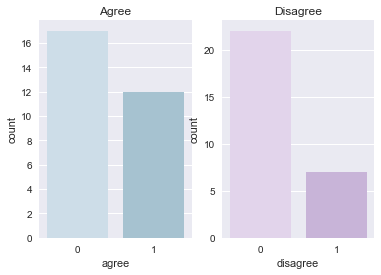

In [554]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(style="darkgrid")
ax = plt.subplot(1,2,1)
sns.countplot(x="agree", data=new_df2, palette = sns.cubehelix_palette(n_colors = 7, start = 2.4, rot = .1), ax = ax)
ax.set_title('Agree')

ax = plt.subplot(1,2,2)
sns.countplot(x="disagree", data=new_df2, palette = sns.cubehelix_palette(n_colors = 7, start = 3, rot = .1), ax = ax)
ax.set_title('Disagree')